# Executive Summary Report for Pneumonia Detection From X-Ray Images
                                                                                                  - Prince Verma (32121973)
## Introduction
This a mini project done as a part of Healthcare Technologies at UWL.
## Dataset
The dataset comprises 5,863 X-ray images divided into three folders: train, test, and validation. Each image falls into one of two categories: Pneumonia or Normal. These images represent anterior-posterior chest X-rays of pediatric patients aged one to five years, collected from the Guangzhou Women and Children's Medical Center in Guangzhou. To ensure data quality, all chest X-rays underwent initial screening, excluding any scans of low quality or unreadable. The diagnoses for the images were then assessed by two expert physicians before being utilized for training the AI system. Additionally, to mitigate grading errors, a third expert reviewed the evaluation set.

## Image Augmentation
In this step, the images present in dataset were augmented using the ImageGenerator class of the Keras library, then the data was rescaled, zoom, transformed and rotated to increase the diversity of the data so that train of the model can be generalized rather than fixing it training it on the same kind of model.The dataset was divided into small batches and different transformation was done on differnt batched and the process was random.In this project I specially focused on the data augmentation as it is very important step of the process as it gives better training results and helps in reducing overfitting.

## Model the Network
In this project the network used was InceptionNet developed by model this is a DeepCNN model that utilized Fast CNN networks to analyse the images. After intialization of Inception net, Relu was used as an activaiton function for the with 128 layers of the NN, then GlobalAveragerpool used to reduce teh dimensionality of the data, than applied normalization and then defined the output layer using Sigmoid Activation function as it is Binary classification.

## Model Implementation
The model was implemented twice first time it used Adam and then SGD (Stochastic Gradient Descent) as the optimisation techniques firstly only SGD was implemented but the results were not satisfactory then implemented adam and the scores really dropped but then made some changes in the hyperparameters of the network and it produces the accuracy of 98% with recall of 100% and F1 score of 92% while SGD produces the accuracy of 91% with the recall of 95% on the test data that was not seen by the model before.

In conclusion, this project for the pediatric Xray classifcation based on InceptionNet CNN, with image proper image augmentation and changing the hyperparameters it shows that Adam outperformed the SGD in the classifcation problem.



In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
directory=("/content/drive/MyDrive/Pneumonia_Detection/chest_xray/chest_xray/")
ds_train=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Pneumonia_Detection/chest_xray/chest_xray/test')
ds_val=tf.keras.preprocessing.image_dataset_from_directory('/content/drive//MyDrive/Pneumonia_Detection/chest_xray/chest_xray/val')
ds_test=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Pneumonia_Detection/chest_xray/chest_xray/test')

Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import layers, models

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf


In [ ]:
ds_train=ds_train
class_names=ds_train.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:
train_dir = '/content/drive/MyDrive/Pneumonia_Detection/chest_xray/chest_xray/train'
test_dir = '/content/drive/MyDrive/Pneumonia_Detection/chest_xray/chest_xray/test'
val_dir = '/content/drive/MyDrive/Pneumonia_Detection/chest_xray/chest_xray/val'

In [ ]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(directory + _set + '/NORMAL'))
    n_infect = len(os.listdir(directory + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1345, pneumonia images: 3885
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [ ]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=directory+'train',
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=directory+'test',
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

    # making predictions off of the test set in one batch size

    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(directory + 'test' + cond)):
            img = plt.imread(directory +'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

In [ ]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5230 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
test_data.shape

(624, 150, 150, 3)

In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet',include_top=False,input_shape=(img_dims, img_dims, 3))
x = base_model.output

x = Dropout(0.5)(x)
from keras.layers import GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1,activation = 'sigmoid')(x)               #using sigmoid activation fuction to classify as it is a binary classifcation

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
print(output.shape)

(None, 1)


In [ ]:
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model1 = Model(inputs=base_model.input, outputs=output)
model1.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=0.0001,loss_weights=0.0018,weight_decay=0.0002,dropout_prob=0.7,learning_rate=0.0015)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2, mode='min')

In [ ]:
# Callbacks
checkpoint1 = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=0.0001)
lr_reduce1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=2, mode='max')
early_stop1 = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2, mode='min')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0]

In [ ]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0]

In [ ]:
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 692s 4s/step - loss: 0.1579 - accuracy: 0.9479 - val_loss: 0.3518 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 686s 4s/step - loss: 0.1334 - accuracy: 0.9521 - val_loss: 0.6227 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 679s 4s/step - loss: 0.1125 - accuracy: 0.9577 - val_loss: 0.9662 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 686s 4s/step - loss: 0.0872 - accuracy: 0.9694 - val_loss: 0.5609 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9631
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
163/163 [==============================] - 683s 4s/step - loss: 0.1080 - accuracy: 0.9631 - val_loss: 0.4117 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 694s

In [ ]:
hist1 = model1.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint1, lr_reduce1,early_stop1])

Epoch 1/10
163/163 [==============================] - 1820s 11s/step - loss: 0.3119 - accuracy: 0.8809 - val_loss: 0.3431 - val_accuracy: 0.8635 - lr: 0.0100
Epoch 2/10
163/163 [==============================] - 1060s 6s/step - loss: 0.1657 - accuracy: 0.9496 - val_loss: 0.3035 - val_accuracy: 0.8799 - lr: 0.0100
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9571
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
163/163 [==============================] - 1067s 7s/step - loss: 0.1307 - accuracy: 0.9571 - val_loss: 0.2588 - val_accuracy: 0.9013 - lr: 0.0100


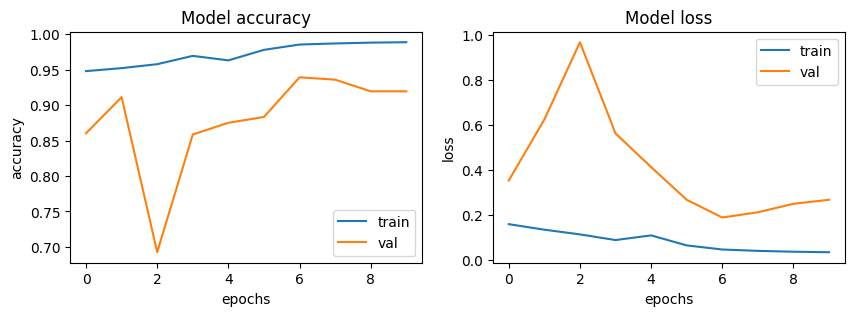

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

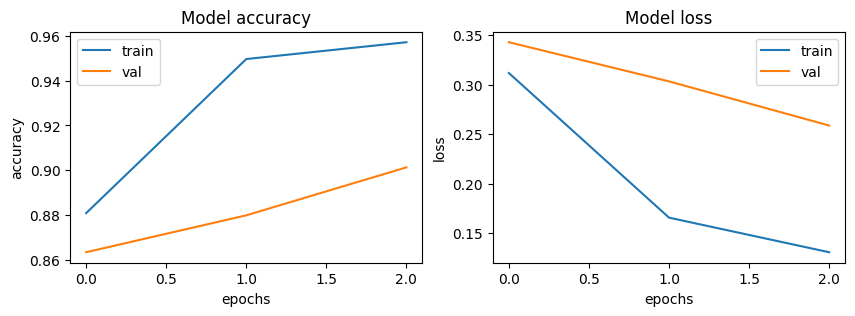

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met1 in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist1.history[met1])
    ax[i].plot(hist1.history['val_' + met1])
    ax[i].set_title('Model {}'.format(met1))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met1)
    ax[i].legend(['train', 'val'])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

20/20 [==============================] - 21s 846ms/step
CONFUSION MATRIX ------------------
[[172  62]
 [  0 390]]

TEST METRICS ----------------------
Accuracy: 90.06410256410257%
Precision: 86.28318584070797%
Recall: 100.0%
F1-score: 92.63657957244656

TRAIN METRIC ----------------------
Train acc: 98.86


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds1 = model1.predict(test_data)

acc1 = accuracy_score(test_labels, np.round(preds1))*100
cm1 = confusion_matrix(test_labels, np.round(preds1))
tn, fp, fn, tp = cm1.ravel()

print('CONFUSION MATRIX ------------------')
print(cm1)

print('\nTEST METRICS ----------------------')
precision1 = tp/(tp+fp)*100
recall1 = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc1))
print('Precision: {}%'.format(precision1))
print('Recall: {}%'.format(recall1))
print('F1-score: {}'.format(2*precision1*recall1/(precision1+recall1)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist1.history['accuracy'][-1])*100, 2)))

20/20 [==============================] - 27s 1s/step
CONFUSION MATRIX ------------------
[[201  33]
 [ 18 372]]

TEST METRICS ----------------------
Accuracy: 91.82692307692307%
Precision: 91.85185185185185%
Recall: 95.38461538461539%
F1-score: 93.58490566037736

TRAIN METRIC ----------------------
Train acc: 95.71


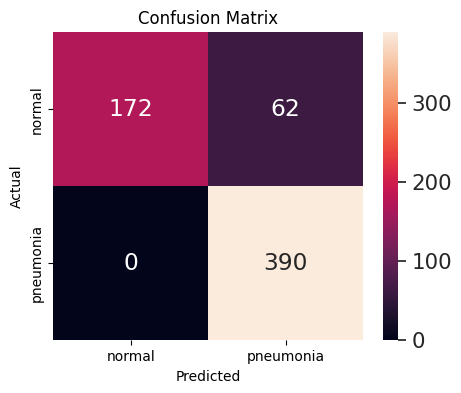

In [ ]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, index = ('normal', 'pneumonia'), columns = ('normal', 'pneumonia'))
plt.figure(figsize = (5,4))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

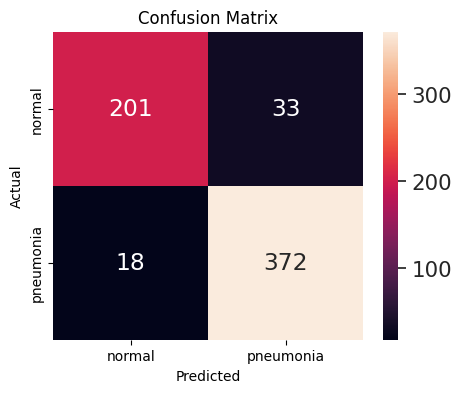

In [ ]:
import seaborn as sn
import pandas as pd
df_cm1 = pd.DataFrame(cm1, index = ('normal', 'pneumonia'), columns = ('normal', 'pneumonia'))
plt.figure(figsize = (5,4))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.set(font_scale=1.4)
sn.heatmap(df_cm1, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Function to load and preprocess images

def load_images(directory):
    images = []
    labels = []
    for folder in os.listdir(directory):
        label = folder
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

#Load images and labels for train, test, and validation sets
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)
X_val, y_val = load_images(val_dir)

#Preprocess labels (convert to binary)
y_train_binary = np.where(y_train == 'PNEUMONIA', 1, 0)
y_test_binary = np.where(y_test == 'PNEUMONIA', 1, 0)
y_val_binary = np.where(y_val == 'PNEUMONIA', 1, 0)

In [ ]:
# 1-Spatial Domain Techniques:

# Gaussian Blur
#The Gaussian Blur technique is applied to blur images, which helps in reducing noise and detail in the image.
X_train_blur = np.array([cv2.GaussianBlur(img, (5, 5), 0) for img in X_train])
X_test_blur = np.array([cv2.GaussianBlur(img, (5, 5), 0) for img in X_test])
X_val_blur = np.array([cv2.GaussianBlur(img, (5, 5), 0) for img in X_val])

# Histogram Equalization
# Enhances the contrast of an image by redistributing intensities, improving visibility of details.
X_train_eq = np.array([cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)) for img in X_train])
X_test_eq = np.array([cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)) for img in X_test])
X_val_eq = np.array([cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)) for img in X_val])


# 2-Frequency Domain Techniques:

# Discrete Cosine Transform (DCT)
#DCT is used to transform spatial data into frequency data.
def apply_dct(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dct_img = cv2.dct(np.float32(img) / 255.0)
    return np.uint8(dct_img * 255)

X_train_dct = np.array([apply_dct(img) for img in X_train])
X_test_dct = np.array([apply_dct(img) for img in X_test])
X_val_dct = np.array([apply_dct(img) for img in X_val])

# High Pass Filter
#High Pass Filter helps in sharpening images by accentuating high-frequency components.
def high_pass_filter(img, d=30):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    fshift[crow - d:crow + d, ccol - d:ccol + d] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back.astype(np.uint8)

X_train_hpf = np.array([high_pass_filter(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)) for img in X_train])
X_test_hpf = np.array([high_pass_filter(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)) for img in X_test])
X_val_hpf = np.array([high_pass_filter(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)) for img in X_val])

In [ ]:
# Visualize three random images for each type of enhancement

def visualize_images(before_imgs, after_imgs, title):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        if i < 3:
            ax.imshow(before_imgs[i])
            ax.set_title('Before ' + title)
        else:
            ax.imshow(after_imgs[i - 3])
            ax.set_title('After ' + title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

#Example of visualization for each enhancement technique
visualize_images(X_train[:3], X_train_blur[:3], 'Gaussian Blur')
visualize_images(X_train[:3], X_train_eq[:3], 'Histogram Equalization')
visualize_images(X_train[:3], X_train_dct[:3], 'Discrete Cosine Transform')
visualize_images(X_train[:3], X_train_hpf[:3], 'High Pass Filter')
visualize_images(X_train[:3], X_train_hpf[:3], 'Salt and pepper')

In [ ]:
#Classifier Testing
def train_and_evaluate_classifier(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(name + ' Accuracy:', accuracy)
    print(name + ' Report:\n', report)

#Setup classifiers
random_forest = RandomForestClassifier()
svm = SVC()
knn = KNeighborsClassifier(n_neighbors=3)

#Test enhanced images using classifiers

train_and_evaluate_classifier(knn, X_train_blur.reshape(-1, 224 * 224 * 3), y_train_binary, X_test_blur.reshape(-1, 224 * 224 * 3), y_test_binary, 'KNN with Gaussian Blur')
train_and_evaluate_classifier(knn, X_train_eq.reshape(-1, 224 * 224), y_train_binary, X_test_eq.reshape(-1, 224 * 224), y_test_binary, 'KNN with Histogram Equalization')
train_and_evaluate_classifier(knn, X_train_dct.reshape(-1, 224 * 224), y_train_binary, X_test_dct.reshape(-1, 224 * 224), y_test_binary, 'KNN with DCT')
train_and_evaluate_classifier(knn, X_train_hpf.reshape(-1, 224 * 224), y_train_binary, X_test_hpf.reshape(-1, 224 * 224), y_test_binary, 'KNN with High Pass Filter')

train_and_evaluate_classifier(random_forest, X_train_blur.reshape(-1, 224 * 224 * 3), y_train_binary, X_test_blur.reshape(-1, 224 * 224 * 3), y_test_binary, 'Random Forest with Gaussian Blur')
train_and_evaluate_classifier(random_forest, X_train_eq.reshape(-1, 224 * 224), y_train_binary, X_test_eq.reshape(-1, 224 * 224), y_test_binary, 'Random Forest with Histogram Equalization')
train_and_evaluate_classifier(random_forest, X_train_dct.reshape(-1, 224 * 224), y_train_binary, X_test_dct.reshape(-1, 224 * 224), y_test_binary, 'Random Forest with DCT')
train_and_evaluate_classifier(random_forest, X_train_hpf.reshape(-1, 224 * 224), y_train_binary, X_test_hpf.reshape(-1, 224 * 224), y_test_binary, 'Random Forest with High Pass Filter')

train_and_evaluate_classifier(svm, X_train_blur.reshape(-1, 224 * 224 * 3), y_train_binary, X_test_blur.reshape(-1, 224 * 224 * 3), y_test_binary, 'SVM with Gaussian Blur')
train_and_evaluate_classifier(svm, X_train_eq.reshape(-1, 224 * 224), y_train_binary, X_test_eq.reshape(-1, 224 * 224), y_test_binary, 'SVM with Histogram Equalization')
train_and_evaluate_classifier(svm, X_train_dct.reshape(-1, 224 * 224), y_train_binary, X_test_dct.reshape(-1, 224 * 224), y_test_binary, 'SVM with DCT')
train_and_evaluate_classifier(svm, X_train_hpf.reshape(-1, 224 * 224), y_train_binary, X_test_hpf.reshape(-1, 224 * 224), y_test_binary, 'SVM with High Pass Filter')

NameError: name 'RandomForestClassifier' is not defined